In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.all_utils import to_categorical
#Keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [2]:
metadata = pd.read_csv('../input/deepglobe-road-extraction-dataset/metadata.csv')
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [3]:
metadata = metadata[metadata['split']=='train']

In [4]:
len(metadata)

6226

In [5]:
metadata.isnull().sum()

image_id          0
split             0
sat_image_path    0
mask_path         0
dtype: int64

In [6]:
metadata['sat_image_path'][0]

'train/100034_sat.jpg'

In [7]:
images = []
masks = []
for i in tqdm(range(6226)):
    path='../input/deepglobe-road-extraction-dataset/'
    image = plt.imread(path+metadata['sat_image_path'][i])
    mask = plt.imread(path+metadata['mask_path'][i])
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    grayimg = mask[:,:,0]*0.2989+mask[:,:,1]*0.5870+mask[:,:,2]*0.1140
    images.append(image)
    masks.append(grayimg)

  0%|          | 0/6226 [00:00<?, ?it/s]

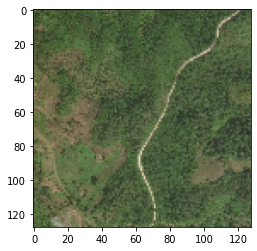

In [8]:
plt.imshow(images[0])

In [9]:
masks[0].shape

(128, 128)

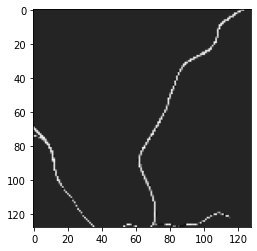

In [10]:
plt.imshow(masks[0],cmap='gray')

### Binarization of masks

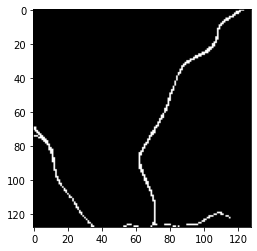

In [11]:
th, im_th = cv2.threshold(masks[0], 0, 255, cv2.THRESH_BINARY)
plt.imshow(im_th,cmap='gray')

In [12]:
bin_masks = []
for mask in tqdm(masks):
    th,im_th = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
    bin_masks.append(im_th)

  0%|          | 0/6226 [00:00<?, ?it/s]

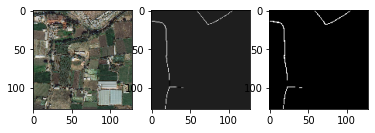

In [13]:
ind = np.random.randint(1000)
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(images[ind])
fig.add_subplot(1,3,2)
plt.imshow(masks[ind],cmap='gray')
fig.add_subplot(1,3,3)
plt.imshow(bin_masks[ind],cmap='gray')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images,masks,test_size=0.1,random_state=42)

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
y_train.shape

(5603, 128, 128)

In [17]:
import tensorflow as tf
y_train=tf.expand_dims(y_train,-1)
y_test=tf.expand_dims(y_test,-1)
y_train.shape,y_test.shape

2022-04-28 03:19:22.354252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 03:19:22.482886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 03:19:22.483649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 03:19:22.486103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(TensorShape([5603, 128, 128, 1]), TensorShape([623, 128, 128, 1]))

### defining functions for unet model

In [18]:
from keras.layers import BatchNormalization,Activation
def conv2dblocks(inputlayer,nfilters,ksize=3,norm=True):
    
    x = Conv2D(filters = nfilters,kernel_size=(ksize,ksize),padding='same')(inputlayer)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = nfilters,kernel_size=(ksize,ksize),padding='same')(x)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [19]:
from keras.layers import Conv2DTranspose,concatenate
import tensorflow as tf
def unet(inputlayer,nfilters,dropouts,norm=True):
    
    c1 = conv2dblocks(inputlayer,nfilters,ksize=3,norm=norm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropouts)(p1)
    
    c2 = conv2dblocks(inputlayer,nfilters*2,ksize=3,norm=norm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropouts)(p2)
    
    c3 = conv2dblocks(inputlayer,nfilters*4,ksize=3,norm=norm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropouts)(p3)
    
    c4 = conv2dblocks(inputlayer,nfilters*8,ksize=3,norm=norm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropouts)(p4)
    
    c5 = conv2dblocks(inputlayer,nfilters*8,ksize=3,norm=norm)
    
    u6 = Conv2DTranspose(nfilters*8, (3, 3), strides = (1, 1), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropouts)(u6)
    c6 = conv2dblocks(u6, nfilters*8, ksize = 3, norm = norm)
    
    u7 = Conv2DTranspose(nfilters*4, (3, 3), strides = (1, 1), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropouts)(u7)
    c7 = conv2dblocks(u7, nfilters*4, ksize = 3, norm = norm)
    
    u8 = Conv2DTranspose(nfilters*2, (3, 3), strides = (1, 1), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropouts)(u8)
    c8 = conv2dblocks(u8, nfilters*2, ksize = 3, norm = norm)
    
    u9 = Conv2DTranspose(nfilters*1, (3, 3), strides = (1, 1), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropouts)(u9)
    c9 = conv2dblocks(u9, nfilters*1, ksize = 3, norm = norm)
    
    output = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputlayer], outputs = [output])
    return model

### Training U-Net model

In [20]:
from keras.layers import Input
inputs = Input((128,128,3))
Unet = unet(inputs,nfilters=16,dropouts=0.2)
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 128, 128, 128 512         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 128 3584        input_1[0][0]                    
______________________________________________________________________________________________

In [21]:
Unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2,name='IOU'),tf.keras.metrics.BinaryAccuracy(name='bin_acc')])

In [23]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True
)

In [24]:
history = Unet.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),callbacks=[callback],verbose=1)

2022-04-28 03:19:41.219378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-28 03:19:44.579120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


176/176 [==============================] - 87s 432ms/step - loss: 0.2797 - accuracy: 0.9292 - IOU: 0.4967 - bin_acc: 0.9292 - val_loss: 0.2701 - val_accuracy: 0.9407 - val_IOU: 0.4966 - val_bin_acc: 0.9407
Epoch 2/50
176/176 [==============================] - 74s 422ms/step - loss: 0.1645 - accuracy: 0.9449 - IOU: 0.4967 - bin_acc: 0.9449 - val_loss: 0.1737 - val_accuracy: 0.9441 - val_IOU: 0.4967 - val_bin_acc: 0.9441
Epoch 3/50
176/176 [==============================] - 74s 422ms/step - loss: 0.1403 - accuracy: 0.9450 - IOU: 0.4967 - bin_acc: 0.9450 - val_loss: 0.1642 - val_accuracy: 0.9441 - val_IOU: 0.4967 - val_bin_acc: 0.9441
Epoch 4/50
176/176 [==============================] - 74s 422ms/step - loss: 0.1306 - accuracy: 0.9441 - IOU: 0.4967 - bin_acc: 0.9441 - val_loss: 0.1518 - val_accuracy: 0.9439 - val_IOU: 0.4967 - val_bin_acc: 0.9439
Epoch 5/50
176/176 [==============================] - 74s 422ms/step - loss: 0.1242 - accuracy: 0.9424 - IOU: 0.4967 - bin_acc: 0.9424 - val_lo

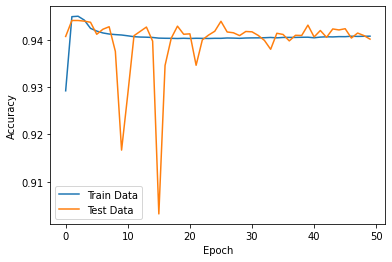

In [25]:
plt.plot(history.history['accuracy'], label='Train Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

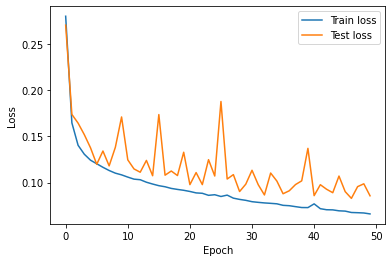

In [26]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

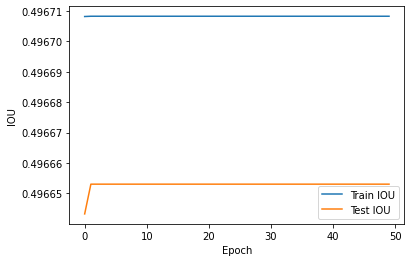

In [27]:
plt.plot(history.history['IOU'], label='Train IOU')
plt.plot(history.history['val_IOU'], label='Test IOU')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='best')
plt.show()

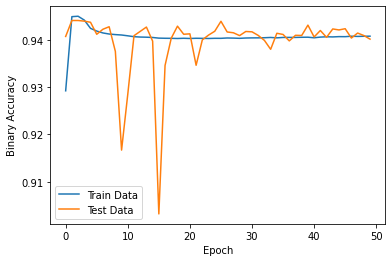

In [29]:
plt.plot(history.history['bin_acc'], label='Train Data')
plt.plot(history.history['val_bin_acc'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend(loc='best')
plt.show()

In [30]:
X_test.shape

(623, 128, 128, 3)

In [31]:
preds = Unet.predict(X_test,verbose=1)

20/20 [==============================] - 2s 110ms/step


In [32]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_test,preds)
miou.result().numpy()

0.49665305

In [33]:
bin_acc = tf.keras.metrics.BinaryAccuracy()
bin_acc.update_state(y_test,preds)
bin_acc.result().numpy()

0.9401271

In [34]:
from tensorflow.keras import backend as K
smooth=100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

In [35]:
dice_coef(y_test,preds).numpy()

0.4821717

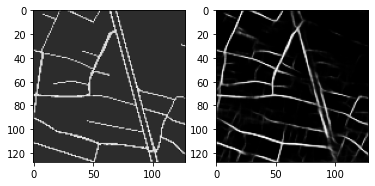

In [37]:
ind = np.random.randint(50)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(y_test[ind],cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(preds[ind],cmap='gray')
plt.show()

In [38]:
Unet.save('model-2-0.4967.h5')